# Captions for CLEF16 Data

ImageCLEF captions come from the subfigure segmentation task where one figure (compound or single) comes with a corresponding caption and the bounding boxes for any subfigure. As we want to use the captions for the subfigure classification, which is derived from segmentation dataset, we need to match the captions to the subfigure classification set.

There is one caveat, the subfigure classification task dataset was built using the subfigure bounding boxes but the captions were not processed to match the subfigure. Hence, the same caption will be repeated for the *n* subfigures in a figure. For example:
* Figure '1471-2202-9-58-19.jpg' (nomenclature in segmentation task) has 3 subfigures.
* Subfigures: '1471-2202-9-58-19**-1**.jpg', '1471-2202-9-58-19**-2**.jpg', '1471-2202-9-58-19**-3**.jpg' (nomenclature in subfigure classification task)
* Caption: "This is a sample caption (A) something, (B) something else, (C) another thing" is assigned to the three subfigures.

How will this affect our classification approach? That's yet to be analyzed, but chopping the subfigures is a way to laborious task.

## Our Data
* Captions:
    * CompoundFigureDetectionTraining2016-Captions.csv
    * CompoundFigureDetectionTest2016-Captions.csv
    * We don't have data for ImageClef13 now.
* Images:
    * Organized in folder per modality

## 1. Data Validation

Verify that each image on the CLEF16 training dataset has a corresponding caption.

In [54]:
import pandas as pd
import json
import os
import re
import csv
from pathlib import Path

In [283]:
BASE_PATH = Path('/workspace/data')
IMAGES16_TRAIN = BASE_PATH / 'subfigure-classification' / '2016' / 'train'
IMAGES16_TEST  = BASE_PATH / 'subfigure-classification' / '2016' / 'test'
IMAGES13_TRAIN = BASE_PATH / 'subfigure-classification' / '2013' / 'train'
IMAGES13_TEST  = BASE_PATH / 'subfigure-classification' / '2013' / 'test'
LABELS16_TEST  = BASE_PATH / 'subfigure-classification' / '2016' / 'test.csv'
CAPTIONS16_TRAIN = BASE_PATH / 'compound-figure-detection' / '2016' / 'captions-train.csv' #CompoundFigureDetectionTraining2016-Captions.csv 
CAPTIONS16_TEST  = BASE_PATH / 'figure-separation' / '2016' / 'captions-test.csv'

DATASET_PATH = BASE_PATH / "multimodality_classification.csv" # output path

I want to create my dataset later with the path to an image, but keeping it relative to wherever I want to place the dataset content. In other words, I don't want to save the **BASE_PATH** in the dataset so I can use it as a parameter. The *pathlib parts* method is handy for this task.

In [117]:
# 3 because of BASE_PATH (start after /data)
Path(*IMAGES16_TRAIN.parts[3:])

PosixPath('subfigure-classification/2016/train')

Obtain the list of image names (**training_ids**) from the CLEF16 image folder

In [133]:
def load_test_modalities16():
    with open(LABELS16_TEST) as csvfile:
        reader = csv.reader(csvfile, delimiter=' ')
        return { '{0}.jpg'.format(x[0]): x[1] for x in reader }

def get_modality(dictionary, key):
    try:
        return dictionary[key]
    except:
        return "NONE"
    
modalities16_test = load_test_modalities16()

In [136]:
# modalities in ImageCLEF13 also considered the class COMP, if we use it, make sure to discard it first
modalities = [x.name for x in IMAGES16_TRAIN.glob('*/')]
train_data_16 = [(img_path.name, modality, Path(*img_path.parts[3:])) for modality in modalities 
                 for img_path in (IMAGES16_TRAIN / modality).glob('*.jpg')]  
# to match with captions
train_ids_16 = [x[0] for x in train_data_16] 

test_data_16 = [(img_path.name, get_modality(modalities16_test, img_path.name), 
                 Path(*img_path.parts[3:]))
                for img_path in IMAGES16_TEST.glob('*.jpg')]
test_ids_16  = [x[0] for x in test_data_16]
test_ids_16[:5]

['12178_2008_9035_Fig6_HTML-1.jpg',
 '12178_2008_9035_Fig6_HTML-2.jpg',
 '1297-9686-41-35-3-1.jpg',
 '1297-9686-41-35-3-2.jpg',
 '1423-0127-16-19-5-1.jpg']

In [336]:
modalities13 = [x for x in IMAGES13_TRAIN.glob('*/') if x.is_dir()]
train_data_13 = [(img_path.name, modality.name, Path(*img_path.parts[3:]))  
       for modality in modalities13 for img_path in (IMAGES13_TRAIN / modality).glob('*.jpg') ]
train_ids_13 = [x[0] for x in train_data_13]

In [121]:
train_data_16[:1]

[('1423-0127-16-109-3-1.jpg',
  'D3DR',
  PosixPath('subfigure-classification/2016/train/D3DR/1423-0127-16-109-3-1.jpg'))]

In [231]:
test_data_16[:1]

[('12178_2008_9035_Fig6_HTML-1.jpg',
  'DRXR',
  PosixPath('subfigure-classification/2016/test/12178_2008_9035_Fig6_HTML-1.jpg'))]

As the main difference in the file namings between datasets is the suffix used in the subfigure classification images, the following functions will become handy to match the image with the captions.

In [64]:
# def match_compound(img_id):
#     p = re.compile('(-|[.])[0-9]*-[0-9]*.(jpg)$')
#     match = p.search(img_id)
#     return True if match != None else False

def get_compound_root(img_id):
    # Obtain the part of the image name without subfigure labeling
    p = re.compile('(-|[.])[0-9]*.(jpg)$')
    match = p.search(img_id)
    m_start, m_end = match.span()
    return img_id[:m_start]

def create_captions_dict(csv_file):
    # create a captions dictionary for a convenient matching
    # works for the FIGURE DETECTION file but this files is incomplete
    captions_dict = {}
    with open(csv_file, encoding='ISO-8859-1') as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        for row in reader:
            captions_dict[row[0]] = row[1]
    return captions_dict

def create_caption_dictionary(csv_file):
    # works with the COMPOUND FIGURE DETECTION file
    captions = {}
    with open(csv_file, encoding='ISO-8859-1') as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        for row in reader:
            # the original file has some empty lines
            if len(row) != 0:
                # lines using tab separators
                if len(row) == 1:
                    sp = row[0].split('\t')
                    if len(sp) == 2:
                        # remove the ,,,,,,,, sequences
                        captions[sp[0]] = sp[1].replace(',,', '').replace("\xa0", "")
                    else:
                        # there is at least one case there the id is not present
                        # so the line has only one value
                        captions[sp[0]] = ''
                elif len(row) == 2:
                    captions[row[0]] = row[1]
    return captions
            
# Tests match_compound
test = '1471-2202-9-58-19-6.jpg'
test2= 'IJBI2010-105610.007-1.jpg'
test3= '11373_2007_9226_Fig1_HTML-16.jpg'

print(get_compound_root(test))
print(get_compound_root(test2))
print(get_compound_root(test3))

1471-2202-9-58-19
IJBI2010-105610.007
11373_2007_9226_Fig1_HTML


In [67]:
captions16_train = create_caption_dictionary(CAPTIONS16_TRAIN)
captions16_test  = create_caption_dictionary(CAPTIONS16_TEST)

print("There are {num} training subfigures.".format(num=len(image_ids_16)))
print("The captions dictionary has {num} captions".format(num=len(captions16_train.keys())))

There are 6776 training subfigures.
The captions dictionary has 20987 captions


### Check Training Data

In [320]:
def check_captions(ids, captions_dict, get_root=True):
    num_has_caption = 0
    imgs_no_caption = []
    
    for img_id in ids:
        try:
            if get_root:
                caption = captions_dict[get_compound_root(img_id)]
            else:
                caption = captions_dict[img_id[:-4]] # get rid of the file extension
            num_has_caption += 1
        except KeyError:
            imgs_no_caption.append(img_id)
    
    print("{num} subfigures have a corresponding caption".format(num=num_has_caption))
    print("Only {images} have no captions".format(images=(' ').join(imgs_no_caption)))
    return

check_captions(image_ids_16, captions16_train)

6776 subfigures have a corresponding caption
Only  have no captions


After searching for the key in the dictionary, we can see that the problem is the use of **.001** instead of **-001**. We proceed to create a corresponding key.

In [70]:
found = []
for k in captions16_train.keys():
    if 'DRP2011-927852' in k:
        found.append(k)
print(found)

captions16_train['DRP2011-927852-001'] = captions16_train['DRP2011-927852.001']

['DRP2011-927852.001']


In [138]:
check_captions(image_ids_16, captions16_train)

6776 subfigures have a corresponding caption
Only  have no captions


Checking if any subfigure has an empty caption.

In [139]:
count_empty = 0
for img_id in image_ids_16:
    if captions16_train[get_compound_root(img_id)] == '':
        count_empty += 1
        print(img_id)

if count_empty == 0:
    print("There are no subfigure with empty labels")
else:
    print("There are {num} subfigures with empty labels".format(num=count_empty))

There are no subfigure with empty labels


### Check Test Data

In [140]:
check_captions(test_ids_16, captions16_test)

4158 subfigures have a corresponding caption
Only  have no captions


In [321]:
check_captions(train_ids_13, captions16_train, get_root=False)

2875 subfigures have a corresponding caption
Only 1471-2121-4-11-5.jpg 1471-5945-1-9-6.jpg 1471-2474-3-5-2.jpg 1471-2474-3-5-5.jpg cc8332-1.jpg have no captions


## Create Dataframe

In [325]:
import pandas as pd

def get_caption(captions_dict, key, get_root=True):
    try:
        if get_root: return captions_dict[get_compound_root(key)]
        else: return captions_dict[key[:-4]]
    except: return "NULL"

def create_dataset(data, captions_dict, get_root=True):
    df = pd.DataFrame(data, columns =['ID', 'MODALITY', 'PATH'])
    df['CAPTION'] = df.apply(lambda x: get_caption(captions_dict, x['ID'], get_root=get_root), axis=1)                             
    #df['COMPOUND'] = df.apply(lambda x: get_compound_root(x['ID']), axis=1)
    return df

In [337]:
df16_train = create_dataset(train_data_16, captions16_train, get_root=True)
df16_test  = create_dataset(test_data_16, captions16_test, get_root=True)
df13_train = create_dataset(train_data_13, captions16_train, get_root=False)
df_train.head()

,ID,MODALITY,PATH,CAPTION,COMPOUND
0,1423-0127-16-109-3-1.jpg,D3DR,subfigure-classification/2016/train/D3DR/1423-...,A. Three dimensional model of class C protein ...,1423-0127-16-109-3
1,1423-0127-16-109-3-2.jpg,D3DR,subfigure-classification/2016/train/D3DR/1423-...,A. Three dimensional model of class C protein ...,1423-0127-16-109-3
2,1423-0127-17-34-3-1.jpg,D3DR,subfigure-classification/2016/train/D3DR/1423-...,Three domains of AAG A (or C)-chain: (a) domai...,1423-0127-17-34-3
3,1423-0127-17-34-3-2.jpg,D3DR,subfigure-classification/2016/train/D3DR/1423-...,Three domains of AAG A (or C)-chain: (a) domai...,1423-0127-17-34-3
4,1423-0127-17-34-3-3.jpg,D3DR,subfigure-classification/2016/train/D3DR/1423-...,Three domains of AAG A (or C)-chain: (a) domai...,1423-0127-17-34-3


In [338]:
# get rid of samples without captions
df13_train = df13_train[df13_train['CAPTION'] != 'NULL']
df13_train.head()

,ID,MODALITY,PATH,CAPTION
0,1297-9686-41-26-2.jpg,COMP,subfigure-classification/2013/train/COMP/1297-...,Estimated (----) additive genetic variance and...
1,1297-9686-42-13-6.jpg,COMP,subfigure-classification/2013/train/COMP/1297-...,Posterior density curves for Landrace and Larg...
2,1423-0127-16-113-4.jpg,COMP,subfigure-classification/2013/train/COMP/1423-...,Binding of TPR proteins to Hsc70 . ( A ) TPR p...
3,1423-0127-16-17-6.jpg,COMP,subfigure-classification/2013/train/COMP/1423-...,Silencing of Clathrin heavy chain in HepG2 cel...
4,1423-0127-16-35-4.jpg,COMP,subfigure-classification/2013/train/COMP/1423-...,A: The analysis of nuclear factor NF- Îº B and...


In [235]:
# x = df16_train[['ID', 'COMPOUND', 'MODALITY']].groupby(['COMPOUND', 'MODALITY']).agg(['count'])
# x = df16_train[['ID', 'COMPOUND', 'MODALITY']].groupby(['COMPOUND', 'MODALITY']).size()
# x.head(20)

ID
                                   count
COMPOUND                  MODALITY      
11373_2007_9226_Fig1_HTML DMFL        19
12178_2007_9007_Fig1_HTML DMTR         1
                          GHDR         3
12178_2008_9027_Fig4_HTML DRXR         3
12178_2009_9056_Fig9_HTML DRUS         2
1297-9686-42-10-3         GFIG         4
1423-0127-16-109-3        D3DR         2
1423-0127-16-6-3          GFIG         1
                          GGEL         1
1423-0127-16-6-5          GFIG         1
                          GGEL         2
1423-0127-16-7-1          DMEL         5
                          GFIG         1
1423-0127-16-88-1         DMEL         1
                          DMFL         2
                          DMLI         1
                          DRMR         1
1423-0127-17-22-2         GFIG         1
                          GGEL         2
                          GTAB         1

In [341]:
df16_microscopy_train = df16_train[df16_train['MODALITY'].isin(['DMFL', 'DMTR', 'DMLI', 'DMEL'])]
df13_microscopy_train = df13_train[df13_train['MODALITY'].isin(['DMFL', 'DMTR', 'DMLI', 'DMEL'])]
df16_microscopy_test  = df16_test[df16_test['MODALITY'].isin(['DMFL', 'DMTR', 'DMLI', 'DMEL'])]

print(df16_microscopy_train.shape, df13_microscopy_train.shape, df16_microscopy_test.shape)
# df16_microscopy_train.reset_index()
df13_16_microscopy_train = pd.concat([df16_microscopy_train, df13_microscopy_train])
df13_16_microscopy_train.head()

(2110, 4) (220, 4) (873, 4)


,ID,MODALITY,PATH,CAPTION
201,1423-0127-16-7-1-1.jpg,DMEL,subfigure-classification/2016/train/DMEL/1423-...,Scanning electron microscope images of the TiO...
202,1423-0127-16-7-1-2.jpg,DMEL,subfigure-classification/2016/train/DMEL/1423-...,Scanning electron microscope images of the TiO...
203,1423-0127-16-7-1-4.jpg,DMEL,subfigure-classification/2016/train/DMEL/1423-...,Scanning electron microscope images of the TiO...
204,1423-0127-16-7-1-5.jpg,DMEL,subfigure-classification/2016/train/DMEL/1423-...,Scanning electron microscope images of the TiO...
205,1423-0127-16-7-1-6.jpg,DMEL,subfigure-classification/2016/train/DMEL/1423-...,Scanning electron microscope images of the TiO...


In [342]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(df13_16_microscopy_train,
                              test_size=0.2,
                              random_state=43,
                              shuffle=True,
                              stratify=df13_16_microscopy_train['MODALITY'])

In [343]:
df13_16_microscopy_train['SET'] = df13_16_microscopy_train.apply(
    lambda x: 'TRAIN' if x['ID'] in train['ID'].values else 'VAL', axis=1)
df13_16_microscopy_train.tail(20)

,ID,MODALITY,PATH,CAPTION,SET
1351,1477-7819-3-32-2.jpg,DMTR,subfigure-classification/2013/train/DMTR/1477-...,Pathological findings of the left lung. The se...,VAL
1352,1477-7827-4-63-10.jpg,DMTR,subfigure-classification/2013/train/DMTR/1477-...,Immunohistochemical staining of section from t...,TRAIN
1353,1743-8454-5-10-9.jpg,DMTR,subfigure-classification/2013/train/DMTR/1743-...,Fibrosis in senescent rat choroid plexus. Agi...,TRAIN
1354,1746-160X-3-35-5.jpg,DMTR,subfigure-classification/2013/train/DMTR/1746-...,Irregular melanosomes with some inclusions cou...,TRAIN
1355,1749-799X-5-56-6.jpg,DMTR,subfigure-classification/2013/train/DMTR/1749-...,Histological examination . Cyst wall structure...,TRAIN
1356,1750-1172-4-7-17.jpg,DMTR,subfigure-classification/2013/train/DMTR/1750-...,Subepithelial mucinous corneal dystrophy . Tra...,TRAIN
1357,1750-1172-4-7-21.jpg,DMTR,subfigure-classification/2013/train/DMTR/1750-...,Macular corneal dystrophy . Transmission elect...,VAL
1358,1750-1172-4-7-37.jpg,DMTR,subfigure-classification/2013/train/DMTR/1750-...,Granular corneal dystrophy . Characteristic ro...,TRAIN
1359,1750-1172-4-7-60.jpg,DMTR,subfigure-classification/2013/train/DMTR/1750-...,Fuchs corneal dystrophy . Transmission electro...,TRAIN
1360,1751-0147-42-311-3.jpg,DMTR,subfigure-classification/2013/train/DMTR/1751-...,Liver from an animal in group 3 (Cu and Cr def...,VAL


In [344]:
df13_16_microscopy_train.groupby(['SET']).count()

,ID,MODALITY,PATH,CAPTION
SET,,,,
TRAIN,1864,1864,1864,1864
VAL,466,466,466,466


In [345]:
df16_microscopy_test['SET'] = 'TEST'
df16_microscopy_test.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ID,MODALITY,PATH,CAPTION,SET
14,1423-0127-17-78-9-1.jpg,DMFL,subfigure-classification/2016/test/1423-0127-1...,Confocal image of 5-HT 2A receptors in the hi...,TEST
15,1423-0127-17-78-9-2.jpg,DMFL,subfigure-classification/2016/test/1423-0127-1...,Confocal image of 5-HT 2A receptors in the hi...,TEST
16,1423-0127-17-78-9-3.jpg,DMFL,subfigure-classification/2016/test/1423-0127-1...,Confocal image of 5-HT 2A receptors in the hi...,TEST
17,1423-0127-17-78-9-4.jpg,DMFL,subfigure-classification/2016/test/1423-0127-1...,Confocal image of 5-HT 2A receptors in the hi...,TEST
18,1423-0127-17-78-9-5.jpg,DMFL,subfigure-classification/2016/test/1423-0127-1...,Confocal image of 5-HT 2A receptors in the hi...,TEST


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='MODALITY'>

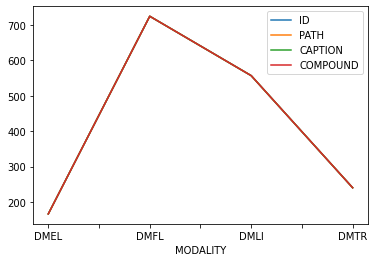

In [265]:
train.groupby(['MODALITY']).count().plot()

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='MODALITY'>

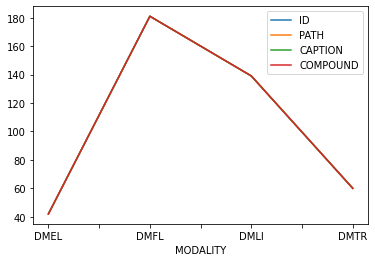

In [266]:
val.groupby(['MODALITY']).count().plot()

In [346]:
df = pd.concat([df13_16_microscopy_train, df16_microscopy_test])
df.shape

(3203, 5)

In [347]:
df.to_csv(DATASET_PATH, sep='\t')

## Check some of the images

1471-2482-6-10-4.jpg
Microscopic aspect of SFT (a) . Microscopic aspect of a solitary fibrous tumor: "Patternless" growth pattern with cellular (right half) and some myxoid (left half) areas, hemangiopericytoma-like wide blood vessels.


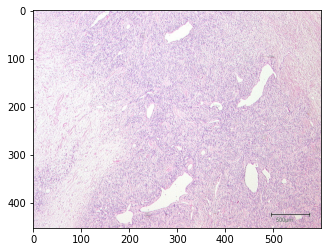

In [362]:
import matplotlib.pyplot as plt
import skimage.io as io

idx = 99
# idx = 100 belong to the same compound figure and has the caption split

img_id = df13_microscopy_train.iloc[idx]['ID']
caption = df13_microscopy_train.iloc[idx]['CAPTION']
image_path = BASE_PATH / df13_microscopy_train.iloc[idx]['PATH']

print(img_id)
print(caption)
img = io.imread(image_path)
plt.imshow(img);

1423-0127-16-7-1-1.jpg
Scanning electron microscope images of the TiO 2  nanoparticles . (A) C150, (B) C200, (C) EDS elemental spectrum of C200, (D)  S. aureus  and UV100, (E)  S. aureus  and C150, and (F)  S. aureus  and C200. Scale bars: 100 nm.


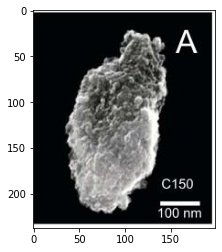

In [363]:
idx = 0

img_id = df16_microscopy_train.iloc[idx]['ID']
caption = df16_microscopy_train.iloc[idx]['CAPTION']
image_path = BASE_PATH / df16_microscopy_train.iloc[idx]['PATH']

print(img_id)
print(caption)
img = io.imread(image_path)
plt.imshow(img);

## Captions Length

In [365]:
df13_microscopy_train['L'] = df13_microscopy_train.apply(lambda x: len(x['CAPTION']), axis=1)
df16_microscopy_train['L'] = df16_microscopy_train.apply(lambda x: len(x['CAPTION']), axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [368]:
print(df13_microscopy_train['L'].mean(), df13_microscopy_train['L'].min(), df13_microscopy_train['L'].max())
print(df16_microscopy_train['L'].mean(), df16_microscopy_train['L'].min(), df16_microscopy_train['L'].max())

181.98181818181817 28 1139
791.1023696682464 21 2949


<AxesSubplot:>

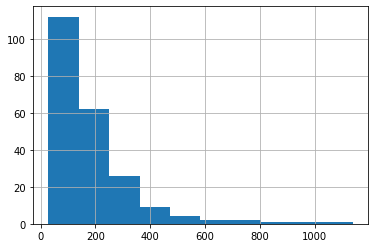

In [369]:
df13_microscopy_train['L'].hist();

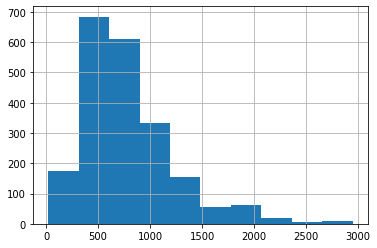

In [370]:
df16_microscopy_train['L'].hist();

## Captions with spatial indicators

Captions in compound figures can use the spatial position of the pane as a reference for the related text in the caption. In the example below (left), the top left image is referenced with the text **(A, top left)** but the image itself does not have an **A** label. As the given subfigure (image below, right) does not have any reference to the **A** label and we cannot guess the position in the original compound image, there is no way to relate just a part of the caption to it.

It's worth noticing that for this particular image, the whole caption may indeed be relevant for any pane just because this is an homogeneous case. For instance, **3-D** is mentioned before any specific pane caption and within pane captions. 

*Image on the left taken from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1508147/*

![10.1186/1472-6807-6-9 Figure 6](./samples/PMC1508147.png)